In [66]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2

import warnings

from contrib.handcrafted_data import syn_dataset
from contrib.differentiable_rendering.sigmoids_renderer.renderer import Renderer
from utils import (
    SyntheticPatch, LinePerturbationPipe, LineRandomShift, LineClip,
    compute_pixel_coords, compute_pixel_density, get_pixel_coords_and_density, wrap_lines_into_numpy_batch,
    torch_to_synthetic_lines
)
from stateful_optimizer import (
    StatefulAligner, 
    LossComposition, 
    init_ot_aligner,
    make_default_loss_fn,
    make_default_optimize_fn,
    store_render_difference, 
    store_grads, 
    save_best_batch
)
from crossing_refiner import CrossingRefinerFull
# from optimize import optimize_line_batch

from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from vectran.data.graphics_primitives import PrimitiveType
import numpy as np
import torch

torch.manual_seed(4)
np.random.seed(4)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Train a neural network for crossings inference

In [2]:
warnings.filterwarnings("ignore")
data = [syn_dataset[i] for i in range(10000)]

In [3]:
for i, sample in enumerate(data):
    data[i]['raster'] = 1 - sample['raster']
    vectors = sample['vector'][PrimitiveType.PT_LINE]
    vectors = vectors[vectors.sum(axis=1) != 0][:, :5]
    data[i]['crossing_raster'] = SyntheticPatch.from_lines(vectors, default_line_rgba=(1., 1., 1., 0.5)).get_image()
    data[i]['crossing_raster'] /= np.max(sample['crossing_raster'])

In [4]:
model = CrossingRefinerFull().to(DEVICE)
model.train(True)
bce = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([1.0]).to(DEVICE))
mse = torch.nn.MSELoss()
l1_loss = torch.nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

dataloader = DataLoader(data, 64, True)
for epoch in range(50):
    for batch in tqdm(dataloader):
        raster = batch['raster'].unsqueeze(dim=1).float().to(DEVICE)
        crossing_raster = batch['crossing_raster'].unsqueeze(dim=1).float().to(DEVICE)

        pred = model.forward(raster)
        loss = l1_loss(pred, crossing_raster) + 0.5 * bce(pred, crossing_raster)
        diff = crossing_raster - pred
#         loss += 0.1 * torch.mean(torch.abs(diff) * torch.relu(diff))
#         loss += torch.abs((torch.max(crossing_raster) - torch.min(crossing_raster)) - (torch.max(crossing_raster) - torch.min(crossing_raster)))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
model.train(False);

100%|██████████| 157/157 [00:03<00:00, 43.01it/s]


CrossingRefinerFull(
  (downscaling_branch): CrossingRefiner(
    (conv1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (upconv1): Sequential(
      (0): Upsample(scale_factor=2.0, mode=bilinear)
      (1): Sequential(
        (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_

## Try the new aligner

In [5]:
def make_animation(image, renders):
    fig = plt.figure()
    ims = []
    for i in range(len(renders)):
        background = plt.imshow(image, animated=True, alpha=0.6, cmap='gray')
        im = plt.imshow(renders[i], animated=True, alpha=0.6)
        ims.append([background, im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)
    
    return ani

In [69]:
np.random.seed(58)


def transform_synthetic_sample(sample):
    vectors = sample['vector'][PrimitiveType.PT_LINE]
    vectors = vectors[vectors.sum(axis=1) != 0][:, :5]

    perturbed_lines = perturber.transform(vectors)
    perturbed_batch = wrap_lines_into_numpy_batch(perturbed_lines)
    perturbed_batch = torch.from_numpy(perturbed_batch).to(DEVICE)
    
    return {
        'line_batch': perturbed_batch,
        'image': 1 - sample['raster']
    }

def accumulate_renders(state):
    if 'renders' not in state:
        state['renders'] = []
    state['renders'].append(state['render'].detach().cpu().numpy())


perturber = LinePerturbationPipe(
    LineRandomShift((-6, 6), (0, 1)),
#     LineClip(0, 63, 0, 63)  # IMPORTANT
)

loss = LossComposition()
loss.add(make_default_loss_fn(bce_schedule=(lambda state: 5.0)))

for random_seed in range(1):
    sample = transform_synthetic_sample(syn_dataset[random_seed])
    image = sample['image']
    # Uncomment to use neural crossing inference
#     image = torch.from_numpy(image).unsqueeze(dim=0).unsqueeze(dim=1)
#     image = model.forward(image.to(DEVICE)).detach().cpu().numpy()[0][0]
    line_batch = sample['line_batch']
    
    aligner = StatefulAligner(line_batch, image)
    init_ot_aligner(aligner, loss_fn=loss, optimize_fn=make_default_optimize_fn(aligner, lr=0.4))
    aligner.add_callback(store_render_difference)
    aligner.add_callback(save_best_batch)
    aligner.add_callback(accumulate_renders)
    
    for _ in range(300):
        aligner.step()

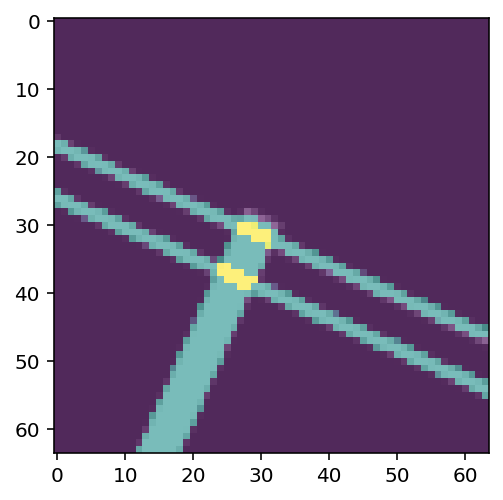

In [70]:
raster = aligner.state['raster'].detach().cpu().numpy()
anim = make_animation(raster, aligner.state['renders'])
HTML(anim.to_html5_video())

##### 